In [1]:
#hide
!pip install datasets
!pip install transformers

In [2]:
#hide
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#hide
# import torch
# from transformers import BertTokenizer, BertForSequenceClassification
# from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
# from transformers import AdamW, get_linear_schedule_with_warmup
# from torch.nn.utils import clip_grad_norm_
# from datasets import load_dataset
# #from sklearn.model_selection import train_test_split
# import pandas as pd
# import numpy as np
# from tqdm.notebook import tqdm


# # compute metrics
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import classification_report
# import matplotlib.pyplot as plt
# import seaborn as sb

## Loading data


In [1]:
import pandas as pd

df = pd.read_csv("D:\\archive\\datasmall.csv")
df.head(5)

C:\Users\huynh\AppData\Local\Temp\ipykernel_25252\2595916360.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,Message,label
0,Suzanne Collins,0
1,J.K. Rowling|Mary GrandPré,0
2,Harper Lee,0
3,Stephenie Meyer,0
4,Markus Zusak,0


In [3]:

from sklearn.model_selection import train_test_split

# Chia dữ liệu thành tập train (80%), validation (10%), và test (10%)
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# In thông tin về kích thước của từng tập dữ liệu
print("Số lượng mẫu trong tập train:", len(train_df))
print("Số lượng mẫu trong tập validation:", len(val_df))
print("Số lượng mẫu trong tập test:", len(test_df))

Số lượng mẫu trong tập train: 2445
Số lượng mẫu trong tập validation: 306
Số lượng mẫu trong tập test: 306


In [4]:
label_names = train_df['label']
label_names

2319    2
2029    2
1373    1
351     0
2915    2
       ..
1638    1
1095    1
1130    1
1294    1
860     0
Name: label, Length: 2445, dtype: int64

Let's take a look at what the text is like:

In [10]:
train_df.head()

,Message,label
2319,Things Fall Apart,2
2029,The Time Traveler's Wife,2
1373,First Edition,1
351,Jack London,0
2915,"Gödel, Escher, Bach: An Eternal Golden Braid",2


In [ ]:
train_df = train_df.groupby('label').apply(lambda x: x.sample(1000)).reset_index(drop=True)
val_df = val_df.groupby('label').apply(lambda x: x.sample(200)).reset_index(drop=True)
test_df = test_df.groupby('label').apply(lambda x: x.sample(140)).reset_index(drop=True)

In [ ]:
train_df['label'].value_counts()

In [77]:
val_df['label'].value_counts()

spam
0    200
1    200
2    200
Name: count, dtype: int64

In [78]:
test_df['spam'].value_counts()

spam
0    140
1    140
2    140
Name: count, dtype: int64

<br>

## Tokenization

Tokenization is a process for spliting raw texts into tokens, and encoding the tokens into numeric data.

To do this, we first initialize a `BertTokenizer`:

In [79]:
from transformers import BertTokenizer
PRETRAINED_LM = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_LM, do_lower_case=True)
tokenizer

BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

define a function for encoding:

In [80]:
def encode(docs):
    encoded_dict = tokenizer.batch_encode_plus(docs, add_special_tokens=True, max_length=128, padding='max_length',
                            return_attention_mask=True, truncation=True, return_tensors='pt')
    input_ids = encoded_dict['input_ids']
    attention_masks = encoded_dict['attention_mask']
    return input_ids, attention_masks

In [81]:
train_input_ids, train_att_masks = encode(train_df['Message'].values.tolist())
valid_input_ids, valid_att_masks = encode(val_df['Message'].values.tolist())
test_input_ids, test_att_masks = encode(test_df['Message'].values.tolist())

<br>

## Creating `Dataset`s and `DataLoader`s

Turn the labels into tensors:

In [83]:
import torch
train_y = torch.LongTensor(train_df['spam'].values.tolist())
val_y = torch.LongTensor(val_df['spam'].values.tolist())
test_y = torch.LongTensor(test_df['spam'].values.tolist())
train_y.size(),val_y.size(),test_y.size()

(torch.Size([3000]), torch.Size([600]), torch.Size([420]))

Create dataloaders for training

In [84]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

BATCH_SIZE = 16
train_dataset = TensorDataset(train_input_ids, train_att_masks, train_y)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_dataset = TensorDataset(valid_input_ids, valid_att_masks, val_y)
valid_sampler = SequentialSampler(valid_dataset)
valid_dataloader = DataLoader(valid_dataset, sampler=valid_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_input_ids, test_att_masks, test_y)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

<br>

## Bert For Sequence Classification Model

In [85]:
from transformers import BertForSequenceClassification
N_labels = len(train_df['label'].unique())
model = BertForSequenceClassification.from_pretrained(PRETRAINED_LM,
                                                      num_labels=N_labels,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [86]:
model = model.cpu()

<br>

## Fine-tuning

### **Optimizer and Scheduler**

In [87]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

EPOCHS = 10
LEARNING_RATE = 2e-6

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer, 
             num_warmup_steps=0,
            num_training_steps=len(train_dataloader)*EPOCHS )

<br>

### **Training Loop**

In [88]:

from torch.nn.utils import clip_grad_norm_
from tqdm.notebook import tqdm
import numpy as np
import math

train_loss_per_epoch = []
val_loss_per_epoch = []


for epoch_num in range(EPOCHS):
    print('Epoch: ', epoch_num + 1)
    '''
    Training
    '''
    model.train()
    train_loss = 0
    for step_num, batch_data in enumerate(tqdm(train_dataloader,desc='Training')):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)
        
        loss = output.loss
        train_loss += loss.item()

        model.zero_grad()
        loss.backward()
        del loss

        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    train_loss_per_epoch.append(train_loss / (step_num + 1))              


    '''
    Validation
    '''
    model.eval()
    valid_loss = 0
    valid_pred = []
    with torch.no_grad():
        for step_num_e, batch_data in enumerate(tqdm(valid_dataloader,desc='Validation')):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

            loss = output.loss
            valid_loss += loss.item()
   
            valid_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
        
    val_loss_per_epoch.append(valid_loss / (step_num_e + 1))
    valid_pred = np.concatenate(valid_pred)

    '''
    Loss message
    '''
    print("{0}/{1} train loss: {2} ".format(step_num+1, math.ceil(len(train_df) / BATCH_SIZE), train_loss / (step_num + 1)))
    print("{0}/{1} val loss: {2} ".format(step_num_e+1, math.ceil(len(valid_df) / BATCH_SIZE), valid_loss / (step_num_e + 1)))

Epoch:  1


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

188/188 train loss: 0.8994180683759933 
38/27 val loss: 0.5881663819676951 
Epoch:  2


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

188/188 train loss: 0.48715359796868996 
38/27 val loss: 0.3067922380409743 
Epoch:  3


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

188/188 train loss: 0.2997469180758963 
38/27 val loss: 0.20915767726929566 
Epoch:  4


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

188/188 train loss: 0.21843199376413164 
38/27 val loss: 0.17914626776779952 
Epoch:  5


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

188/188 train loss: 0.17866006378639251 
38/27 val loss: 0.17242224852701551 
Epoch:  6


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

188/188 train loss: 0.1633505613364755 
38/27 val loss: 0.16919017043945037 
Epoch:  7


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

188/188 train loss: 0.1423695071580562 
38/27 val loss: 0.16543484920341717 
Epoch:  8


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

188/188 train loss: 0.13585415113955102 
38/27 val loss: 0.17422256657951757 
Epoch:  9


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

188/188 train loss: 0.12984856301324166 
38/27 val loss: 0.17262113118838324 
Epoch:  10


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

188/188 train loss: 0.12461626708031968 
38/27 val loss: 0.17323432083388693 


You can see in the output that the training and validation losses steadily decreases in each epoch.

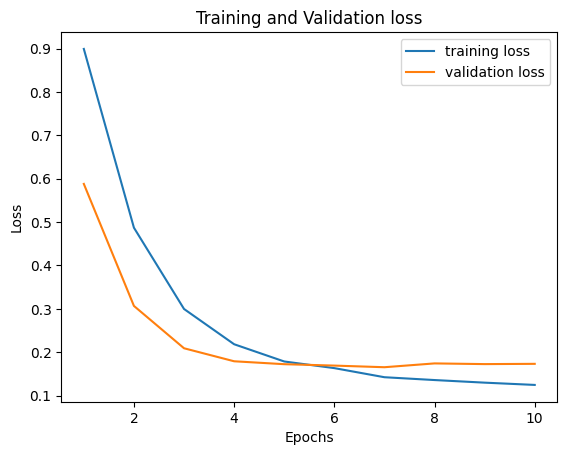

In [89]:
from matplotlib import pyplot as plt
epochs = range(1, EPOCHS +1 )
fig, ax = plt.subplots()
ax.plot(epochs,train_loss_per_epoch,label ='training loss')
ax.plot(epochs, val_loss_per_epoch, label = 'validation loss' )
ax.set_title('Training and Validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

## Performance Metrics
It's common to use precision, recall, and F1-score as the performance metrics.

In [96]:
from sklearn.metrics import classification_report
print('classifiation report')
print(classification_report(valid_pred, val_df['spam'].to_numpy()))

classifiation report
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       203
           1       0.96      0.95      0.96       203
           2       0.92      0.94      0.93       194

    accuracy                           0.95       600
   macro avg       0.95      0.95      0.95       600
weighted avg       0.95      0.95      0.95       600



## Error Analysis
With the predictions, we can plot the confusion matrix:

In [97]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_preds, y_true, labels=None):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels) 
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False) 
  plt.title("Normalized confusion matrix")
  plt.show()

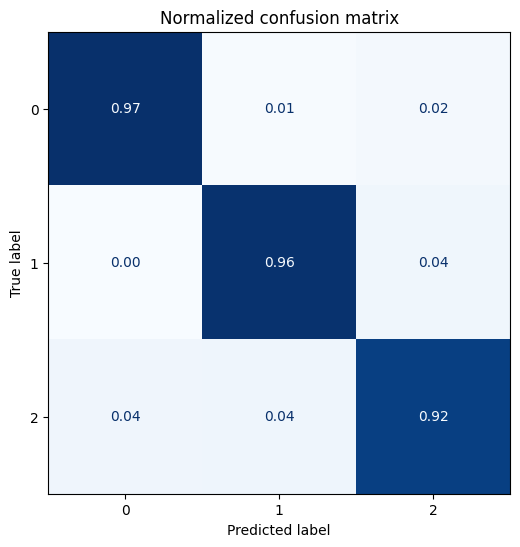

In [102]:
plot_confusion_matrix(valid_pred,val_df['spam'].to_numpy())

You can see that **sadness** has a higher likelihood to be classified as **anger** or **fear**, leading to a lower f1 score.

<br>

## Prediction

*Now* let's use the trained model to predict the testing set.

In [360]:
model.eval()
test_pred = []
test_loss= 0
with torch.no_grad():
    for step_num, batch_data in tqdm(enumerate(test_dataloader)):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        loss = output.loss
        test_loss += loss.item()
   
        test_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
test_pred = np.concatenate(test_pred)

0it [00:00, ?it/s]

In [106]:
print('classifiation report')
print(classification_report(test_pred, test_df['spam'].to_numpy()))

classifiation report
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       145
           1       0.95      0.96      0.95       139
           2       0.93      0.96      0.94       136

    accuracy                           0.96       420
   macro avg       0.96      0.96      0.96       420
weighted avg       0.96      0.96      0.96       420



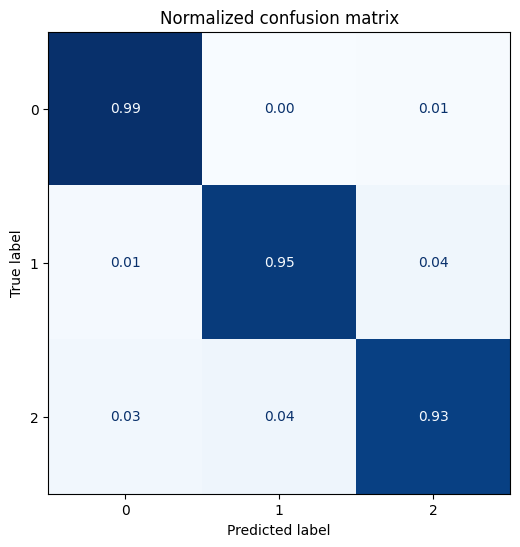

In [107]:
plot_confusion_matrix(test_pred,test_df['spam'].to_numpy())

Output the misclassified text:

In [108]:
test_df['pred'] = test_pred
test_df.reset_index(level=0)
print(test_df[test_df['spam']!=test_df['pred']].shape)
test_df[test_df['spam']!=test_df['pred']][['Message','spam','pred']].head(10)

(18, 3)


,Message,spam,pred
123,Elite Summaries,0,2
147,Clásicos del Terror,1,2
151,"Sign of Love, Sagittarius",1,2
189,Babel,1,2
194,Eerste druk,1,2
234,Everyman Wodehouse,1,0
241,Leer y Pensar,1,2
268,العدد الخامس,1,0
284,اللاهوت العربي وأصول العنف الديني,2,1
313,Hipólito,2,0


In [126]:
# Đường dẫn đến nơi bạn muốn lưu mô hình
save_path = 'D:\\archive\\model.pth'

# Lưu mô hình
torch.save(model.state_dict(), save_path)

# In thông báo lưu thành công
print(f'Mô hình đã được lưu tại: {save_path}')

Mô hình đã được lưu tại: D:\archive\model.pth


DEMO

In [394]:
user_text = "The Secret to success"
encoded_user_input = tokenizer(user_text, truncation=True, padding=True, return_tensors='pt')


In [395]:
model.eval()

with torch.no_grad():
    outputs = model(encoded_user_input['input_ids'], attention_mask=encoded_user_input['attention_mask'])
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    print(predicted_class)

2
